<a href="https://colab.research.google.com/github/aishwarya-agrawal/twitter-analysis/blob/master/ULMFitontweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [0]:
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded['Tweets.csv'].decode('utf-8')))

In [8]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American'], dtype=object)

In [10]:
df.shape

(14640, 15)

In [12]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train,test = train_test_split(df, test_size=0.33, random_state=42)

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)



In [24]:
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

CPU
PyTorch version:  1.0.1.post2


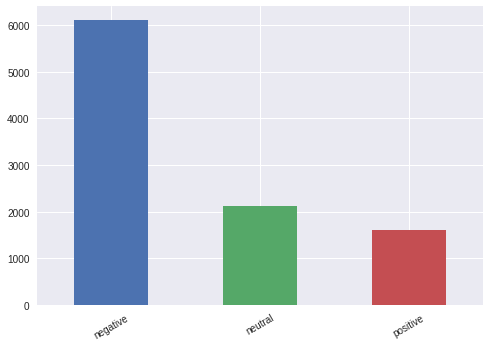

In [28]:
train['airline_sentiment'].value_counts().plot.bar(rot=30);

In [33]:


print("unique airlines are \n")
print("------------------------------------------")
for item in train['airline'].unique():
    print(item)




unique airlines are 

------------------------------------------
Delta
American
Southwest
US Airways
United
Virgin America


In [36]:
train['text'] = train['text'].apply(clean_ascii)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
train.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
7475,569577005278064640,neutral,0.6529,NaN,NaN,Delta,NaN,PumaSF,NaN,0,@JetBlue of course I am!!,NaN,2015-02-22 11:18:34 -0800,San Francisco,Pacific Time (US & Canada)
14324,569633482915209216,negative,1.0000,Late Flight,0.6668,American,NaN,MarciNeedham,NaN,0,@AmericanAir complt incompetence on flt 295.La...,NaN,2015-02-22 15:03:00 -0800,NaN,NaN
6472,567829997668470785,negative,0.6566,Late Flight,0.3385,Southwest,NaN,DontenPhoto,NaN,0,@SouthwestAir Flight 4968 (N8325D) departs @MC...,NaN,2015-02-17 15:36:35 -0800,"Englewood, Florida",Eastern Time (US & Canada)
9675,569725021951791104,negative,1.0000,Can't Tell,0.6917,US Airways,NaN,ThomasBowser19,NaN,0,@USAirways does anyone from your airline know ...,NaN,2015-02-22 21:06:44 -0800,NaN,NaN
4047,567852278893416448,neutral,0.6837,NaN,NaN,United,NaN,DanielBmxUs,NaN,0,@united I Want a Plane dad,NaN,2015-02-17 17:05:08 -0800,└A,Eastern Time (US & Canada)


In [41]:
train1 = pd.concat([train['airline_sentiment'], train['text']], axis=1)
train1.tail()

,airline_sentiment,text
5191,positive,@SouthwestAir replacing @vitaminwater with bee...
13418,negative,@AmericanAir at LAX and your service reps just...
5390,negative,@SouthwestAir Been on hold for over an hour - ...
860,negative,@united we would...how do I contact you to dis...
7270,neutral,@JetBlue that's ok! It just sure seemed like i...


In [45]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [53]:
!mkdir train

mkdir: cannot create directory ‘train’: File exists


In [0]:
train1.to_csv('train/train.csv', index=False, header=False)

In [0]:
data_lm = TextLMDataBunch.from_csv('train/', 'train.csv', min_freq=1)

In [0]:
# Save the language and classifier model data for re-use
data_lm.save()

In [62]:
data_lm.show_batch()

idx,text
0,i was very xxmaj late xxmaj flight for my connecting flight and they got me on ! ! ! xxbos @usairways xxmaj what a great way to kick someone when they are down . xxmaj cancelled xxmaj flight a noon flight and rebook me on one two hours south from here tomorrow xxbos @southwestair http : / / t.co / ttxrsynlxr does n't work on my flight . xxmaj just
1,"the flight takes off xxbos @virginamerica xxmaj nice , xxmaj lofty xxmaj view @flylaxairport . # silverstatus http : / / t.co / f4tp0dawbd xxbos @americanair xxup help ! xxmaj attempting to xxmaj cancelled xxmaj flight a flight but ca n't get thru 800 number . xxmaj call gets dropped when saying xxmaj agent . flight is 2 / 24 . xxbos @southwestair @imaginedragons please help me and my best"
2,trouble we were put through . xxbos @americanair please email me at temorris2010@hotmail.com . willing to discuss my experience & & give another try would like to speak directly xxbos @jetblue thanks xxbos @united i will give it a couple more weeks . xxmaj thank you . xxbos @americanair no date on when revieving our money sent a letter in post and several emails no reply ? ? very frustrated
3,out of xxup smf not very helpful . xxbos @americanair seats that were assigned are inappropriate for child this age . xxup aa knew age of child . xxbos @americanair you have now lost my luggage for40 hours holding for4 hrs on phone # wtf is this how you treat your loyal passengers ? # stranded xxbos @southwestair xxup lost xxmaj kay xxmaj chapman xxmaj designs art - luggage for
4,http : / / t.co / wrwqrublps via @ubergizmo xxbos @southwestair xxup free xxmaj cable xxmaj out of this xxmaj world xxmaj technology and a mans dream come true ... xxup free and xxup portable ? ? ? ! ! ! http : / / t.co / qw1til96ya xxbos @jetblue xxmaj is it only $ 50 for my 2nd bag ? 1st bag too full .. xxbos @americanair xxmaj pathetic


In [0]:
learn = language_model_learner(data_lm,arch=AWD_LSTM, pretrained=True, drop_mult=0.1)

In [67]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(11136, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(11136, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=11136, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


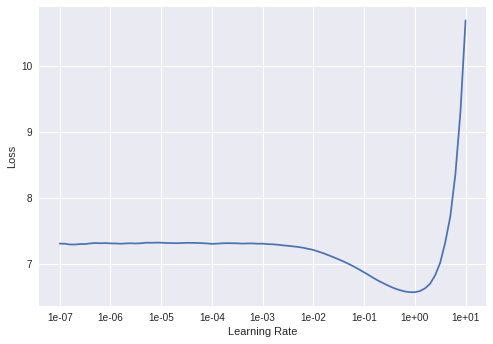

In [69]:


learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()



In [71]:


learn = language_model_learner(data_lm,arch =AWD_LSTM, pretrained=True, 
                               drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
1,7.096560,6.552851,0.154038,09:43


In [72]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,6.407645,5.525712,0.185795,14:34
2,5.952067,5.142346,0.206088,14:30
3,5.577484,4.740348,0.221774,14:29
4,5.110592,4.321959,0.246449,14:29
5,4.744259,4.174666,0.253998,14:35
6,4.468499,4.079595,0.261526,14:48
7,4.243645,4.027777,0.266396,14:40
8,4.063825,4.001522,0.270028,14:46
9,3.894905,4.004245,0.270860,14:49
10,3.743873,4.001704,0.270515,14:51


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [75]:
for item in train.airline.unique():
    print(item)

Delta
American
Southwest
US Airways
United
Virgin America


In [0]:
topic = "Delta"

In [0]:
# Get only those tweets that pertain to a single topic in the training data
train_topic = train1.loc[train['airline'] == topic]

In [0]:

train_topic.to_csv('train/train_topic.csv', index=False, header=False)

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv('train/', 'train_topic.csv', vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)
data_clas.save()


In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.5,arch =AWD_LSTM)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


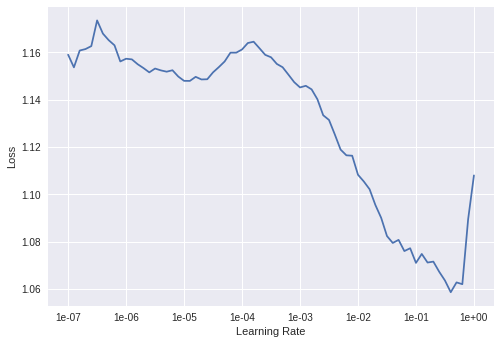

In [83]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [84]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.010142,0.936642,0.588435,00:58


In [85]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.891781,0.768028,0.666667,01:09


In [86]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.800370,0.733424,0.676871,02:05


In [87]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.744176,0.723811,0.700680,02:55
2,0.745511,0.733568,0.704082,02:57
3,0.709958,0.741660,0.670068,02:55
4,0.718688,0.736416,0.697279,03:00


In [88]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,93,28,10
1,17,55,18
2,6,10,57


In [89]:
test = test.drop(['tweet_id'], axis=1)
# test['Tweet'] = test['Tweet'].apply(clean_ascii)
test.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
4794,positive,1.0000,NaN,NaN,Southwest,NaN,JasmineDT,NaN,1,@SouthwestAir you're my early frontrunner for ...,NaN,2015-02-22 21:30:54 -0800,Washington D.C.,Eastern Time (US & Canada)
10480,negative,1.0000,Cancelled Flight,1.0000,US Airways,NaN,ElizabethFrayer,NaN,0,@USAirways how is it that my flt to EWR was Ca...,NaN,2015-02-21 14:32:19 -0800,NaN,NaN
8067,negative,1.0000,Late Flight,0.6770,Delta,NaN,The_Radifier,NaN,0,@JetBlue what is going on with your BDL to DCA...,NaN,2015-02-20 09:05:13 -0800,"Arlington, VA",Atlantic Time (Canada)
8880,neutral,1.0000,NaN,NaN,Delta,NaN,rnlewisjr,NaN,0,@JetBlue do they have to depart from Washingto...,NaN,2015-02-17 12:01:29 -0800,"iPhone: 60.495510,-151.064590",Alaska
8292,negative,0.6625,Customer Service Issue,0.3394,Delta,NaN,beantoon,NaN,0,@JetBlue I can probably find some of them. Are...,NaN,2015-02-19 13:44:20 -0800,"Plymouth, MA",NaN


In [90]:
test_pred = test[['airline', 'text']]
test_pred = test_pred.loc[test_pred['airline'] == topic]
test_pred.tail()

,airline,text
7573,Delta,@JetBlue Thanks for the personalized customer ...
8159,Delta,@JetBlue probably not anymore.
7456,Delta,@JetBlue wondering if it's possible for my col...
8700,Delta,@JetBlue's CEO Battles to Appease Passengers a...
7831,Delta,@JetBlue Kudos to JetBlue social media team fo...


In [0]:
test_pred['airline_sentiment'] = test_pred['text'].apply(lambda row: str(learn.predict(row)[0]))

In [0]:
!cd train

In [102]:
!ls

adc.json  sample_data  train  Tweets.csv


In [0]:
!mkdir test/eval

In [0]:
test_pred.to_csv('test/eval/predicted.txt', sep='\t', index=True,
                 header=['Target', 'Tweet', 'Stance'], index_label='ID')